<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>
Автор материала: Екатерина Демидова, Data Scientist @ Segmento <br>


Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.
Автор материала: 

# <center>Домашнее задание № 2 (демо). <br> Визуальный анализ данных о публикациях на Хабрахабре</center>

**Заполните код в клетках и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1y8qj5iYpaVhczjWnZuHd5NRR_sdCGy3eTF5n-qPKknQ).**

In [86]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка и знакомство с данными

Для работы вам понадобятся предобработанные данные нашего учебного конкурса на kaggle [«Прогноз популярности статьи на Хабре»](https://www.kaggle.com/c/howpop-habrahabr-favs).

In [87]:
df = pd.read_csv('../data/howpop_train.csv')

In [88]:
df.shape

(134137, 17)

In [89]:
df.head(5)

,url,domain,post_id,published,author,flow,polling,content_len,title,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
0,https://habrahabr.ru/post/18284/,habrahabr.ru,18284,2008-01-01 18:19:00,@Tapac,develop,False,4305,Новогодний подарок блоггерам — WordPress 2.3.2,0,0,236,0.0,0.0,-0.792687,-1.344075,-2.436871
1,https://habrahabr.ru/post/18285/,habrahabr.ru,18285,2008-01-01 18:30:00,@DezmASter,design,False,7344,"Сумасшедшие яйца, или сервис для отслеживания ...",1,1,353,1.0,0.0,-0.485214,-0.831946,-1.873193
2,https://habrahabr.ru/post/18286/,habrahabr.ru,18286,2008-01-01 18:34:00,@DezmASter,design,False,8431,"Сумасшедшие яйца, или сервис для отслеживания ...",47,72,1200,45.0,5.0,0.446090,1.794023,0.574656
3,https://habrahabr.ru/post/18291/,habrahabr.ru,18291,2008-01-02 01:32:00,@Taoorus,design,False,5662,"Сглаживание шрифтов, и субпиксельная отрисовка",102,36,5700,72.0,3.0,1.627469,1.300050,1.167375
4,https://geektimes.ru/post/18294/,geektimes.ru,18294,2008-01-02 14:34:00,@dennydo,NaN,False,3706,Почему мне не нравится iPhone,230,6,1400,73.0,15.0,1.362397,0.961094,2.020356


Избавимся сразу от переменных, названия которых заканчиваются на `_lognorm` (нужны для соревнования на Kaggle). Выберем их с помощью `filter()` и удалим `drop`-ом:

In [90]:
df.drop(filter(lambda c: c.endswith('_lognorm'), df.columns), 
        axis = 1,       # axis = 1: столбцы 
        inplace = True) # избавляет от необходимости сохранять датасет

In [91]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
post_id,134137.0,181307.054265,81766.350702,18284.0,115565.0,182666.0,257401.0,314088.0
content_len,134137.0,7516.929699,8724.771640,1.0,2179.0,4949.0,9858.0,352471.0
comments,134137.0,39.625994,62.398958,0.0,7.0,19.0,48.0,2266.0
favs,134137.0,71.999866,145.854135,0.0,8.0,27.0,78.0,8718.0
views,134137.0,16631.013084,31479.819691,3.0,2100.0,7600.0,18700.0,1730000.0
votes_plus,133566.0,35.536888,42.461073,0.0,11.0,22.0,45.0,1466.0
votes_minus,133566.0,8.050035,11.398282,0.0,2.0,5.0,10.0,445.0


In [92]:
df.describe(include = ['object', 'bool'] # бинарные и категориальные переменные
           ).T

,count,unique,top,freq
url,134137,134137,https://geektimes.ru/post/270598/,1
domain,134137,2,habrahabr.ru,97048
published,134137,130291,2011-06-14 15:52:00,39
author,97657,22077,@alizar,5292
flow,97048,6,develop,53318
polling,134137,2,False,129412
title,134137,133628,"Интересные события, произошедшие в выходные",56


In [93]:
# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })

Столбец **`published`** (время публикации) содержит строки. Чтобы мы могли работать с этими данными как с датой/временем публикации, приведём их к типу `datetime`:

In [94]:
print(df.published.dtype)
df['published'] = pd.to_datetime(df.published, yearfirst = True)
print(df.published.dtype)

object
datetime64[ns]


Создадим несколько столбцов на основе данных о времени публикации:

In [95]:
df['year'] = [d.year for d in df.published]
df['month'] = [d.month for d in df.published]
df['day'] = [d.day for d in df.published]
df['dayofweek'] = [d.isoweekday() for d in df.published]
df['hour'] = [d.hour for d in df.published]

-----
Теперь Ваша очередь. В каждом пункте предлагается построить картинку и с ее помощью ответить на вопрос в [форме](https://docs.google.com/forms/d/e/1FAIpQLSf3b5OG8zX_nLQBQ-t20c6M5Auz-VUL-yxj8Fm9_o_XWDBTrg/viewform?c=0&w=1). Конечно, можно попытаться ответить на все вопросы только с Pandas, без картинок, но мы советуем Вам потренироваться строить (красивые) визуализации.   

## 1\. В каком месяце (и какого года) было больше всего публикаций?

* март 2016
* март 2015
* апрель 2015
* апрель 2016

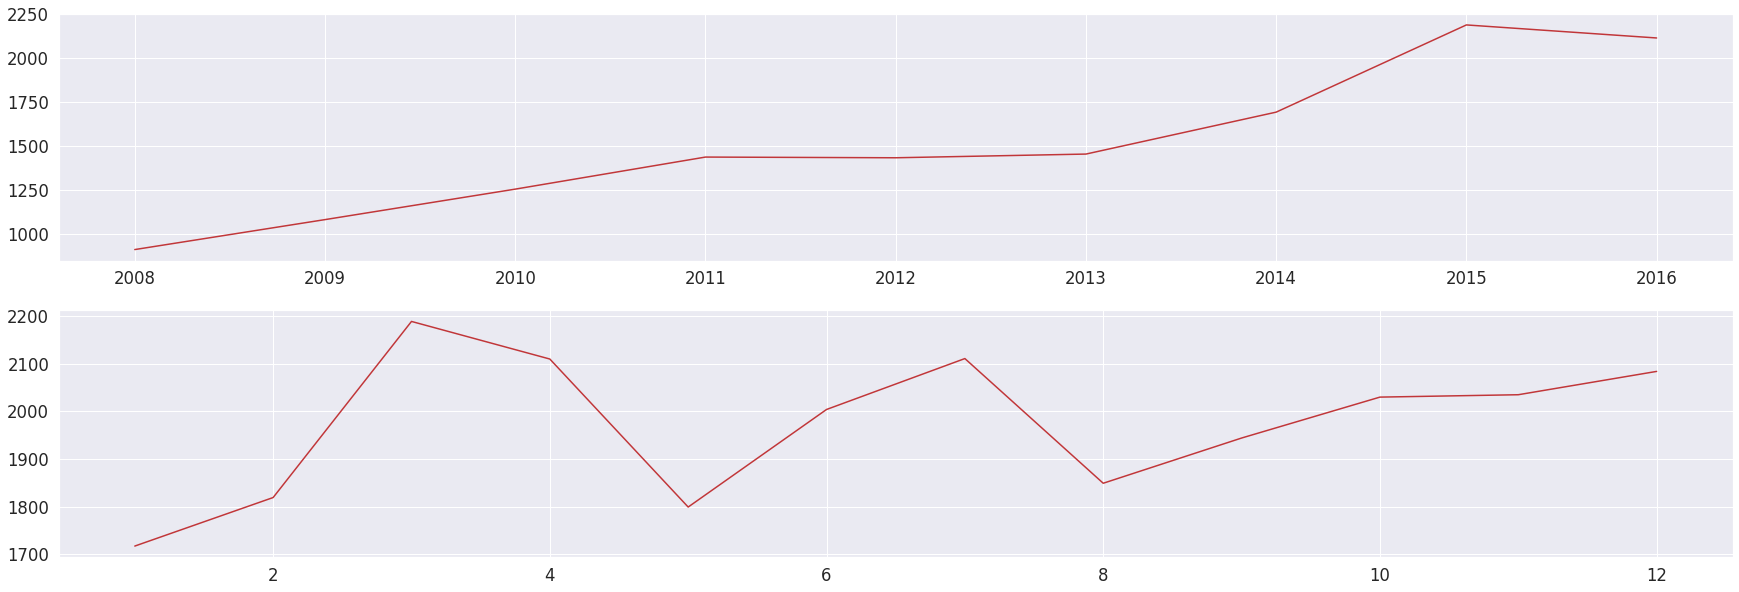

In [177]:
fig , ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(30)

year = df.groupby(['year', 'month'])['url'].count().max(level=0)
month = df.groupby(['year', 'month'])['url'].count().max(level=1)
plt.subplot(2,1,1)
plt.grid()
plt.plot(year.index, year.values)
plt.subplot(2,1,2)
plt.grid()
plt.plot(month.index, mounth.values);

## 2\. Проанализируйте публикации в месяце из предыдущего вопроса

Выберите один или несколько вариантов:

* Один или несколько дней сильно выделяются из общей картины
* На хабре _всегда_ больше статей, чем на гиктаймсе
* По субботам на гиктаймс и на хабрахабр публикуют примерно одинаковое число статей

Подсказки: постройте график зависимости числа публикаций от дня; используйте параметр `hue`; не заморачивайтесь сильно с ответами и не ищите скрытого смысла :)

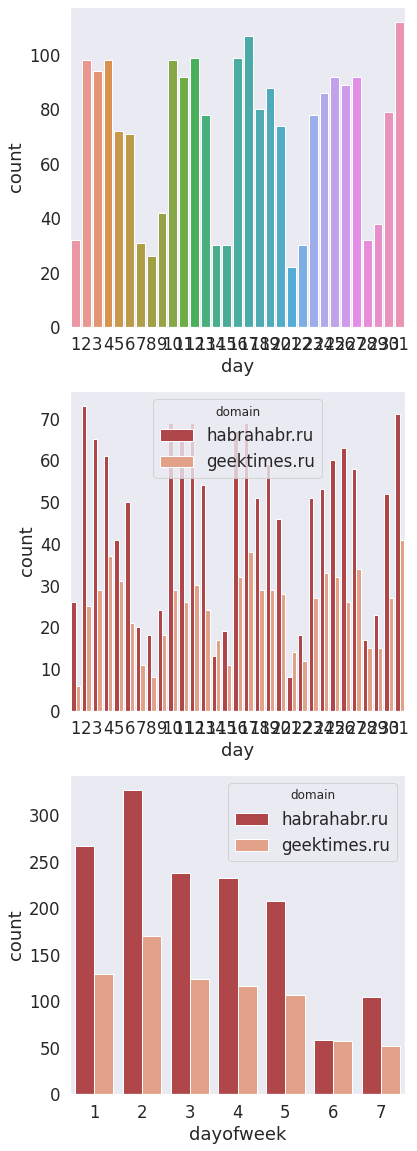

In [155]:
fig , ax = plt.subplots()
fig.set_figheight(20)
plt.subplot(3,1,1)
sns.countplot(df[(df['month'] == 3) & (df['year'] == 2015)]['day'])
plt.subplot(3,1,2)
sns.countplot(x='day',hue='domain', data=df[(df['month'] == 3) & (df['year'] == 2015)])
plt.subplot(3,1,3)
sns.countplot(x='dayofweek',hue='domain', data=df[(df['month'] == 3) & (df['year'] == 2015)]);

## 3\. Когда лучше всего публиковать статью?

* Больше всего просмотров набирают статьи, опубликованные в 12 часов дня
* У опубликованных в 10 утра постов больше всего комментариев
* Больше всего просмотров набирают статьи, опубликованные в 6 часов утра
* Максимальное число комментариев на гиктаймсе набрала статья, опубликованная в 9 часов вечера
* На хабре дневные статьи комментируют чаще, чем вечерние

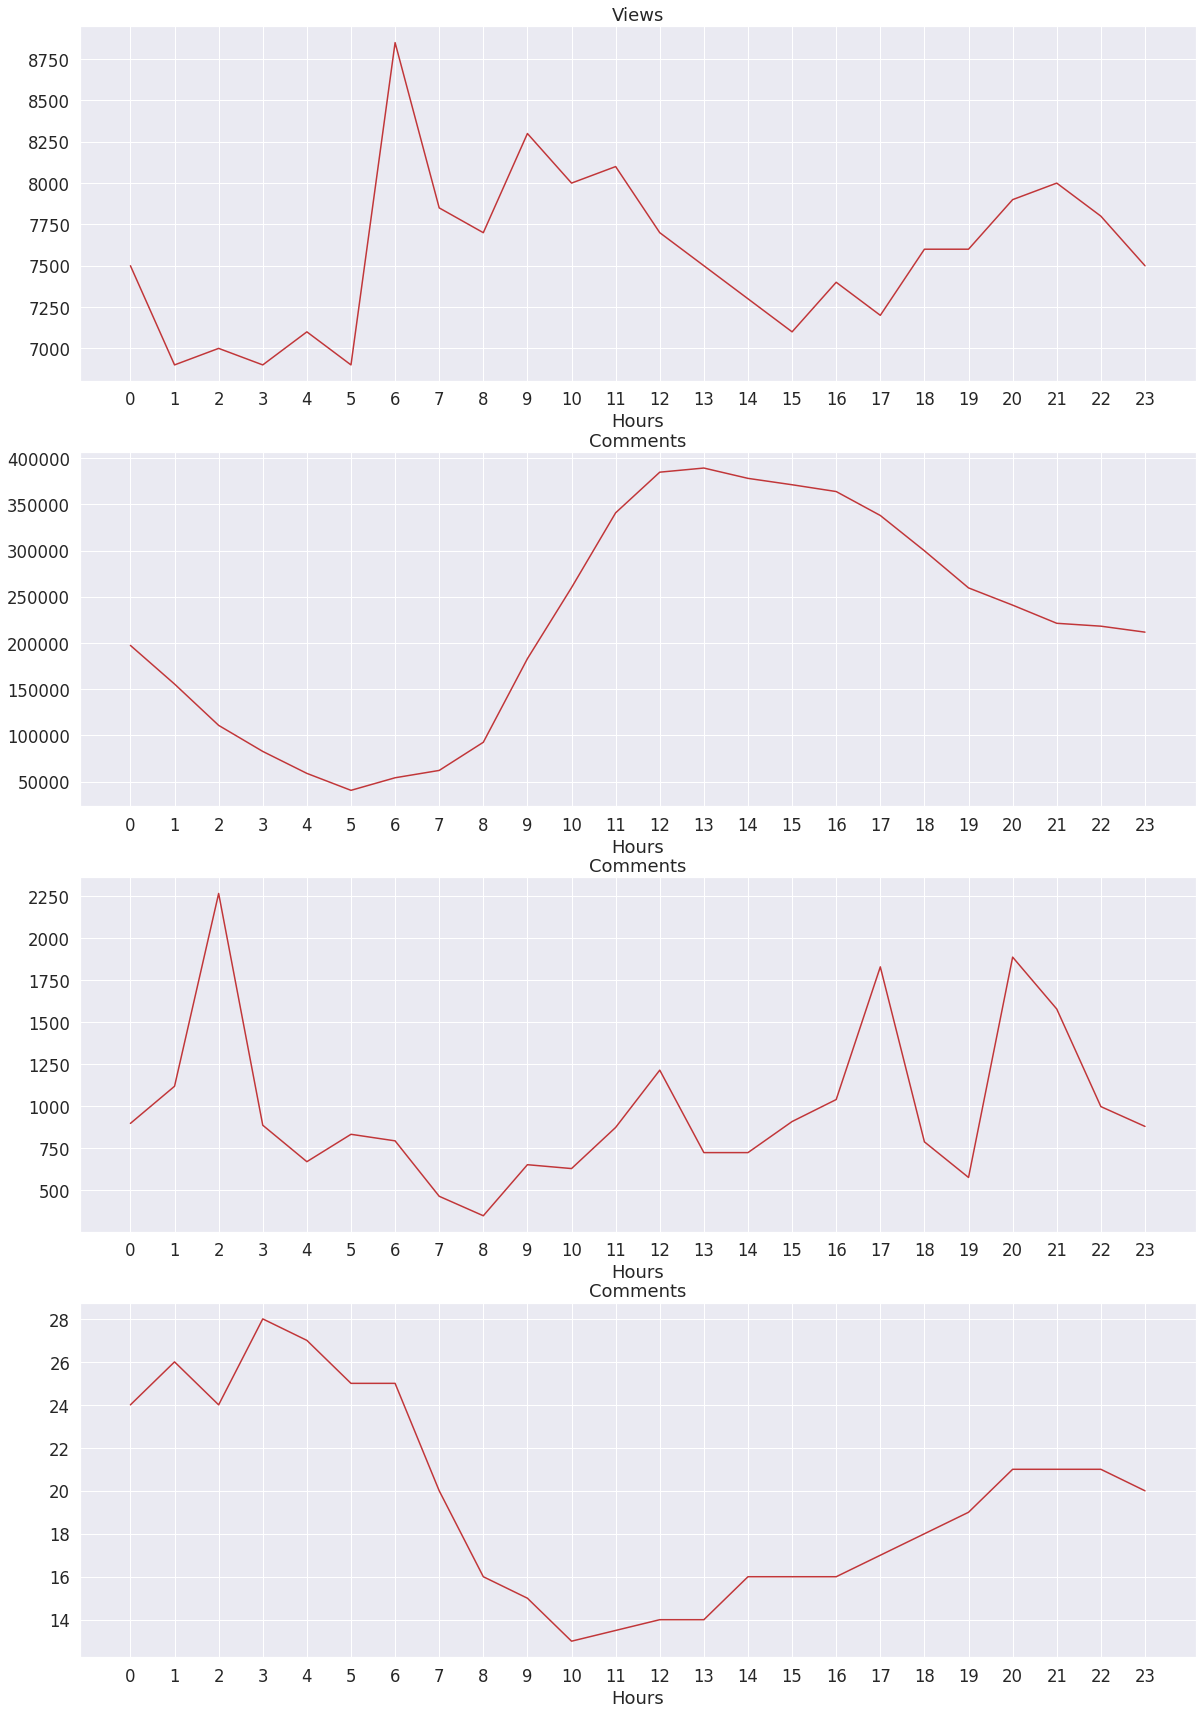

In [154]:
fig , ax = plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(20)

plt.subplot(4,1,1)
first = df.groupby('hour')['views'].median()
plt.title('Views')
plt.xlabel('Hours')
plt.xticks(np.linspace(0,23,24))
plt.grid()
plt.plot(first.index, first.values)

plt.subplot(4,1,2)
second = df.groupby('hour')['comments'].sum()
plt.title('Comments')
plt.xlabel('Hours')
plt.xticks(np.linspace(0,23,24))
plt.grid()
plt.plot(second.index, second.values)

plt.subplot(4,1,3)
third = df[df['domain'] == 'geektimes.ru'].groupby('hour')['comments'].max()
plt.title('Comments')
plt.xlabel('Hours')
plt.xticks(np.linspace(0,23,24))
plt.grid()
plt.plot(third.index, third.values)

plt.subplot(4,1,4)
fourth = df[df['domain'] == 'habrahabr.ru'].groupby('hour')['comments'].median()
plt.title('Comments')
plt.xlabel('Hours')
plt.xticks(np.linspace(0,23,24))
plt.grid()
plt.plot(fourth.index, fourth.values);


## 4\. Кого из топ-20 авторов чаще всего минусуют?

* @Mordatyj
* @Mithgol
* @alizar
* @ilya42

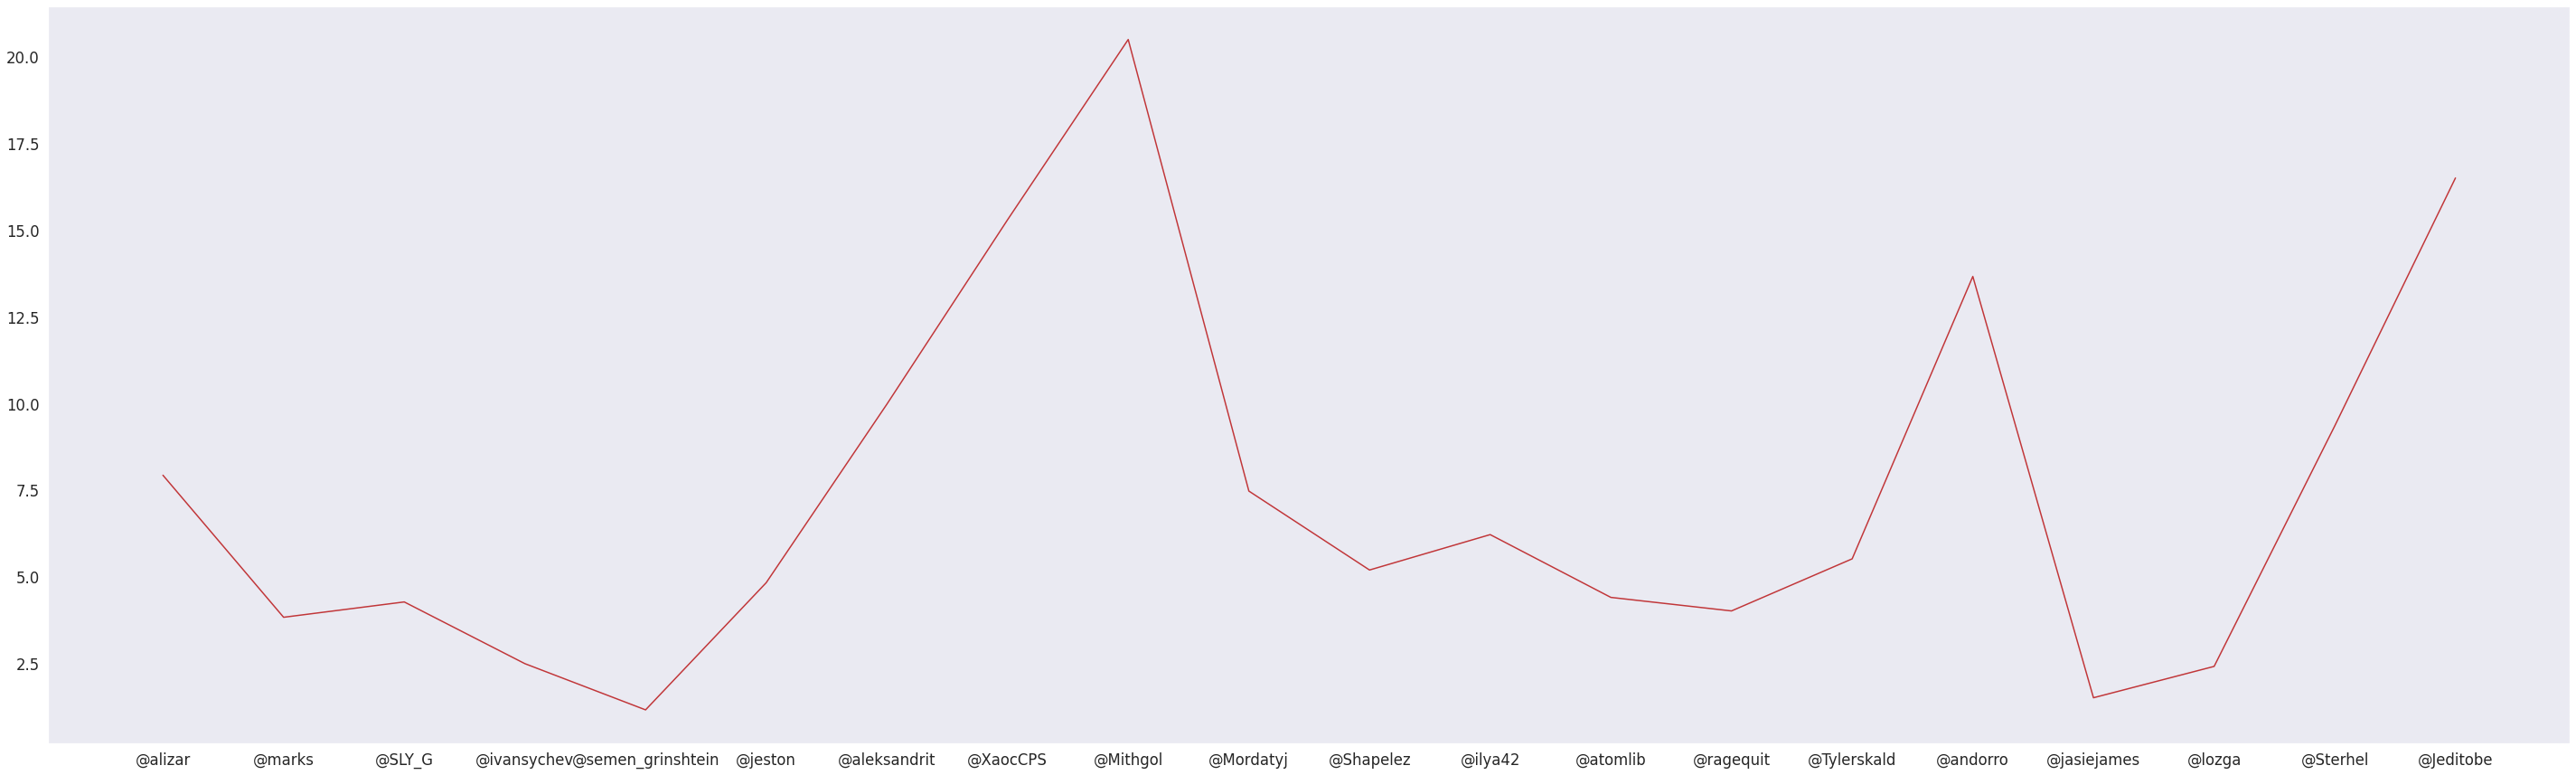

In [199]:
top = df.groupby('author')['favs'].count().sort_values(ascending=False).head(20).index.values
minus = df.groupby('author')['votes_minus'].mean()[top]
fig , ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(50)
plt.plot(top, minus.values);

## 5\. Сравните субботы и понедельники

Правда ли, что по субботам авторы пишут в основном днём, а по понедельникам — в основном вечером?

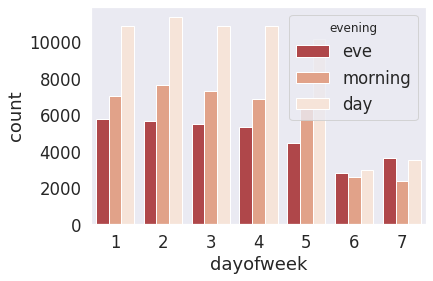

In [185]:
df['evening'] = df['hour'].apply(lambda h: 'eve' if h>=18 else 'day' if h >= 12 else 'morning')
sns.countplot(x='dayofweek', hue='evening', data=df)